# Usa.gov data from bit.ly

This demo is based on an example in the book: https://www.amazon.com/dp/1449319793/

_Python for Data Analysis_ by William Wesley McKinney (O'Reilly). Copyright 2012 William McKinney, 978-1-449-31979-3

The data are available at:
https://github.com/usagov/1.USA.gov-Data

## Setup

- Install Anaconda from https://www.continuum.io/downloads
- Set the account name, user name and password to the environment variables to ``SF_ACCOUNT``, ``SF_USER`` and ``SF_PASSWORD``
- Set the S3 Bucket, AWS access key id and AWS secret access key to ``SF_S3_BUCKET``, ``AWS_ACCESS_KEY_ID`` and ``AWS_SECRET_ACCESS_KEY`` to load the daata from the given location.
- Start Jupyter notebook
```jupyter notebook```

In [1]:
import os
account=os.getenv('SF_ACCOUNT')
user=os.getenv('SF_USER')
password=os.getenv('SF_PASSWORD')

## Create Tables and Load Data

In [2]:
from snowflake.connector import connect
con = connect(
    account=account,
    user=user,
    password=password,
    database='testdb',
    schema='public',
)
cur = con.cursor()

In [3]:
cur.execute("select current_database(), current_schema()").fetchone()

('TESTDB', 'PUBLIC')

In [4]:
cur.execute("create or replace table usagov_bitly(data variant)")

In [5]:
aws_key=os.getenv("AWS_ACCESS_KEY_ID")
aws_secret = os.getenv("AWS_SECRET_ACCESS_KEY")
sf_s3_bucket=os.getenv("SF_S3_BUCKET")

Update the source data location to your S3 bucket.

In [6]:
cur.execute("""
copy into usagov_bitly from s3://{s3_bucket}/usagov/data/
    credentials=(
        aws_key_id='{aws_key_id}' 
        aws_secret_key='{aws_secret_key}'
    )
    file_format= (
        field_delimiter='none'
        type='json'
    )
""".format(
        s3_bucket=sf_s3_bucket,
        aws_key_id=aws_key,
        aws_secret_key=aws_secret))

## Counting Time Zones in Pure Python

In [7]:
from snowflake.connector.cursor import DictCursor
cur = con.cursor(DictCursor)

In [8]:
cur.execute("""
select
    data:a::string  as a,
    data:al         as al,
    data:c          as c,
    data:cy         as cy,
    data:g          as g,
    data:gr         as gr,
    data:h          as h,
    data:hc::float  as hc,
    data:hh         as hh,
    data:l          as l,
    data:ll         as ll,
    data:nk::float  as nk,
    data:r          as r,
    data:t::float   as t,
    data:tz::string as tz,
    data:u          as u
from usagov_bitly as v""")

In [9]:
time_zones = [rec['TZ'] for rec in cur.fetchall() if rec['TZ'] is not None]

In [10]:
len(time_zones)

89726

In [11]:
time_zones[:10]

['America/Chicago',
 'America/Chicago',
 'Asia/Calcutta',
 'America/Chicago',
 'America/Los_Angeles',
 'America/Phoenix',
 'America/Guayaquil',
 'America/Chicago',
 'America/New_York',
 'America/Chicago']

In [12]:
from collections import defaultdict
def get_counts(sequence):
    counts = defaultdict(int)
    for x in sequence:
        counts[x] += 1
    return counts

In [13]:
counts = get_counts(time_zones)

In [14]:
counts['America/New_York']

20067

In [15]:
def top_counts(count_dict, n=10):
    value_key_pairs = [(count, tz) for tz, count in count_dict.items()]
    value_key_pairs.sort()
    return value_key_pairs[-n:]

In [16]:
top_counts(counts)

[(811, 'Europe/Berlin'),
 (847, 'America/Phoenix'),
 (862, 'Asia/Tokyo'),
 (1123, 'America/Rainy_River'),
 (1862, 'America/Denver'),
 (3063, 'Europe/London'),
 (7318, 'America/Los_Angeles'),
 (12031, ''),
 (20067, 'America/New_York'),
 (29742, 'America/Chicago')]

In [17]:
from collections import Counter
counts = Counter(time_zones)
counts.most_common(10)

[('America/Chicago', 29742),
 ('America/New_York', 20067),
 ('', 12031),
 ('America/Los_Angeles', 7318),
 ('Europe/London', 3063),
 ('America/Denver', 1862),
 ('America/Rainy_River', 1123),
 ('Asia/Tokyo', 862),
 ('America/Phoenix', 847),
 ('Europe/Berlin', 811)]

## Counting Time Zones with pandas

In [18]:
from sqlalchemy import create_engine
from snowflake.sqlalchemy import URL
engine = create_engine(URL(
    account=account,
    user=user,
    password=password,
    database='testdb',
    schema='public',
    ))

In [19]:
from pandas import DataFrame, Series
import pandas as pd

In [20]:
%matplotlib notebook

In [21]:
df = pd.read_sql_query("""
select
    data:a::string  as a,
    data:al         as al,
    data:c          as c,
    data:cy         as cy,
    data:g          as g,
    data:gr         as gr,
    data:h          as h,
    data:hc::float  as hc,
    data:hh         as hh,
    data:l          as l,
    data:ll         as ll,
    data:nk::float  as nk,
    data:r          as r,
    data:t::float   as t,
    data:tz::string as tz,
    data:u          as u
from usagov_bitly as v""", engine)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90926 entries, 0 to 90925
Data columns (total 16 columns):
a     89726 non-null object
al    77930 non-null object
c     89726 non-null object
cy    77751 non-null object
g     89726 non-null object
gr    77751 non-null object
h     89726 non-null object
hc    89726 non-null float64
hh    89726 non-null object
l     89726 non-null object
ll    77723 non-null object
nk    89726 non-null float64
r     89726 non-null object
t     89726 non-null float64
tz    89726 non-null object
u     89726 non-null object
dtypes: float64(3), object(13)
memory usage: 11.1+ MB


In [23]:
df['tz'][:10]

0        America/Chicago
1        America/Chicago
2          Asia/Calcutta
3        America/Chicago
4    America/Los_Angeles
5        America/Phoenix
6      America/Guayaquil
7        America/Chicago
8       America/New_York
9        America/Chicago
Name: tz, dtype: object

In [24]:
tz_counts = df['tz'].value_counts()

In [25]:
tz_counts[:10]

America/Chicago        29742
America/New_York       20067
                       12031
America/Los_Angeles     7318
Europe/London           3063
America/Denver          1862
America/Rainy_River     1123
Asia/Tokyo               862
America/Phoenix          847
Europe/Berlin            811
Name: tz, dtype: int64

In [26]:
clean_tz = df['tz'].fillna('Missing')

In [27]:
clean_tz[clean_tz == ''] = 'Unknown'

In [28]:
tz_counts = clean_tz.value_counts()

In [29]:
tz_counts[:10]

America/Chicago        29742
America/New_York       20067
Unknown                12031
America/Los_Angeles     7318
Europe/London           3063
America/Denver          1862
Missing                 1200
America/Rainy_River     1123
Asia/Tokyo               862
America/Phoenix          847
Name: tz, dtype: int64

<IPython.core.display.Javascript object>


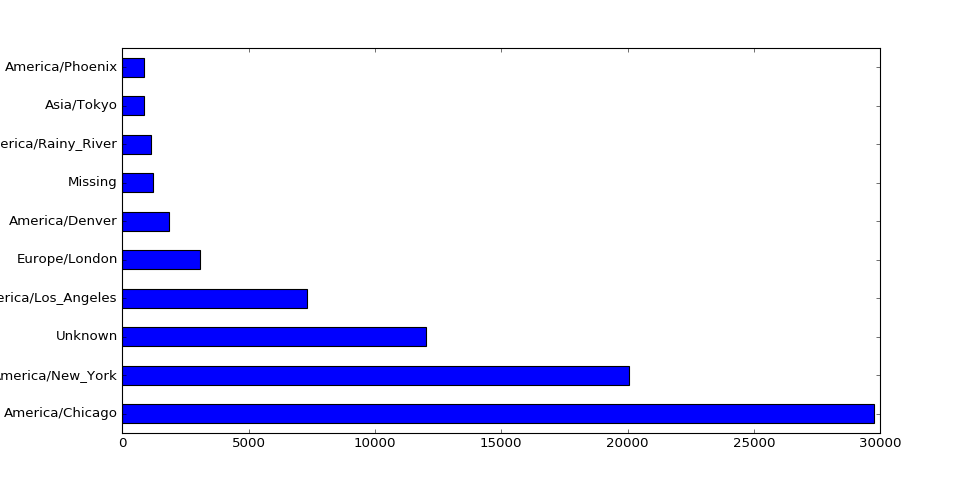

In [30]:
tz_counts[:10].plot(kind='barh', rot=0)

In [31]:
df['a'][1]

'Mozilla/5.0 (iPad; CPU OS 6_1_3 like Mac OS X) AppleWebKit/536.26 (KHTML, like Gecko) Mobile/10B329'

In [32]:
df['a'][50]

'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.31 (KHTML, like Gecko) Chrome/26.0.1410.64 Safari/537.31'

In [33]:
results = Series([x.split()[0] for x in df.a.dropna()])

In [34]:
results[:5]

0    Mozilla/5.0
1    Mozilla/5.0
2    Mozilla/4.0
3    Mozilla/4.0
4    Mozilla/5.0
dtype: object

In [35]:
results.value_counts()[:8]

Mozilla/5.0           64347
Mozilla/4.0           22149
Opera/9.80              707
CakePHP                 399
ShortLinkTranslate      306
Dalvik/1.6.0            300
TVersity                282
iCoreService            201
dtype: int64

In [36]:
cframe = df[df.a.notnull()]

In [37]:
import numpy as np

In [38]:
operating_system= np.where(cframe['a'].str.contains('Windows'), 'Windows', 'Not Windows')

In [39]:
operating_system[:5]

array(['Windows', 'Not Windows', 'Windows', 'Windows', 'Not Windows'], 
      dtype='<U11')

In [40]:
by_tz_os = cframe.groupby(['tz', operating_system])

In [41]:
agg_counts = by_tz_os.size().unstack().fillna(0)

In [42]:
agg_counts[:10]

,Not Windows,Windows
tz,,
,8250.0,3781.0
Africa/Accra,1.0,4.0
Africa/Algiers,2.0,22.0
Africa/Blantyre,0.0,1.0
Africa/Cairo,20.0,26.0
Africa/Casablanca,2.0,13.0
Africa/Ceuta,57.0,52.0
Africa/Dakar,0.0,1.0
Africa/Dar_es_Salaam,4.0,2.0


In [43]:
indexer = agg_counts.sum(1).argsort()

In [44]:
indexer[:10]

tz
                        221
Africa/Accra            136
Africa/Algiers           26
Africa/Blantyre          29
Africa/Cairo            128
Africa/Casablanca       123
Africa/Ceuta            120
Africa/Dakar            114
Africa/Dar_es_Salaam     37
Africa/Gaborone         109
dtype: int64

In [45]:
count_subset = agg_counts.take(indexer)[-10:]

In [46]:
count_subset

,Not Windows,Windows
tz,,
Europe/Berlin,307.0,504.0
America/Phoenix,333.0,514.0
Asia/Tokyo,770.0,92.0
America/Rainy_River,340.0,783.0
America/Denver,558.0,1304.0
Europe/London,2020.0,1043.0
America/Los_Angeles,3051.0,4267.0
,8250.0,3781.0
America/New_York,7155.0,12912.0


<IPython.core.display.Javascript object>


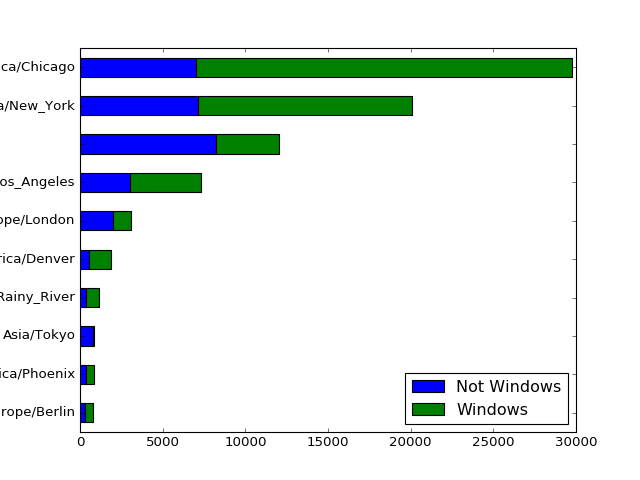

In [47]:
count_subset.plot(kind='barh', stacked=True)

In [49]:
normed_subset = count_subset.div(count_subset.sum(1), axis=0)

<IPython.core.display.Javascript object>


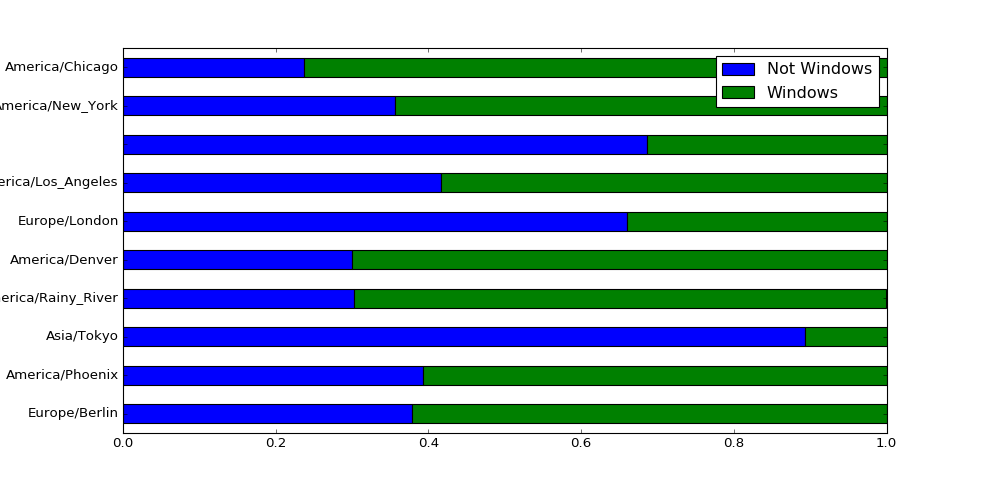

In [50]:
normed_subset.plot(kind='barh', stacked=True)